# MLP model
This file use 'features_3_sec.csv' as input and trained MLP models.
This file requires python packges:
tensorflow 2.3.1
sklearn 1.0.2
numpy 1.18.5

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
%matplotlib inline
import sklearn.metrics as skm
import sklearn.model_selection as skms
import sklearn.preprocessing as skp
import random
seed = 12
np.random.seed(seed)

In [2]:
df = pd.read_csv('./Data/features_3_sec.csv')
df.head()

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.0.wav,66149,0.335406,0.091048,0.130405,0.003521,1773.065032,167541.630869,1972.744388,117335.771563,...,39.687145,-3.241280,36.488243,0.722209,38.099152,-5.050335,33.618073,-0.243027,43.771767,blues
1,blues.00000.1.wav,66149,0.343065,0.086147,0.112699,0.001450,1816.693777,90525.690866,2010.051501,65671.875673,...,64.748276,-6.055294,40.677654,0.159015,51.264091,-2.837699,97.030830,5.784063,59.943081,blues
2,blues.00000.2.wav,66149,0.346815,0.092243,0.132003,0.004620,1788.539719,111407.437613,2084.565132,75124.921716,...,67.336563,-1.768610,28.348579,2.378768,45.717648,-1.938424,53.050835,2.517375,33.105122,blues
3,blues.00000.3.wav,66149,0.363639,0.086856,0.132565,0.002448,1655.289045,111952.284517,1960.039988,82913.639269,...,47.739452,-3.841155,28.337118,1.218588,34.770935,-3.580352,50.836224,3.630866,32.023678,blues
4,blues.00000.4.wav,66149,0.335579,0.088129,0.143289,0.001701,1630.656199,79667.267654,1948.503884,60204.020268,...,30.336359,0.664582,45.880913,1.689446,51.363583,-3.392489,26.738789,0.536961,29.146694,blues


In [3]:
data = df.iloc[0:, 1:]
y = data['label']
X = data.loc[:, data.columns != 'label']

# normalize
cols = X.columns
min_max_scaler = skp.MinMaxScaler()
np_scaled = min_max_scaler.fit_transform(X)
X = pd.DataFrame(np_scaled, columns = cols)

In [4]:
label_index = dict()
index_label = dict()
for i, x in enumerate(df.label.unique()):
    label_index[x] = i
    index_label[i] = x
print(label_index)
print(index_label)

{'blues': 0, 'classical': 1, 'country': 2, 'disco': 3, 'hiphop': 4, 'jazz': 5, 'metal': 6, 'pop': 7, 'reggae': 8, 'rock': 9}
{0: 'blues', 1: 'classical', 2: 'country', 3: 'disco', 4: 'hiphop', 5: 'jazz', 6: 'metal', 7: 'pop', 8: 'reggae', 9: 'rock'}


In [5]:
df.label = [label_index[l] for l in df.label]

In [6]:
df_shuffle = df.sample(frac=1, random_state=seed).reset_index(drop=True)

In [7]:
df_shuffle.drop(['filename', 'length'], axis=1, inplace=True)
df_y = df_shuffle.pop('label')
df_X = df_shuffle

# split into train dev and test
X_train, df_test_valid_X, y_train, df_test_valid_y = skms.train_test_split(df_X, df_y, train_size=0.7, random_state=seed, stratify=df_y)
X_dev, X_test, y_dev, y_test = skms.train_test_split(df_test_valid_X, df_test_valid_y, train_size=0.66, random_state=seed, stratify=df_test_valid_y)

In [8]:
print(f"Train set has {X_train.shape[0]} records out of {len(df_shuffle)} which is {round(X_train.shape[0]/len(df_shuffle)*100)}%")
print(f"Dev set has {X_dev.shape[0]} records out of {len(df_shuffle)} which is {round(X_dev.shape[0]/len(df_shuffle)*100)}%")
print(f"Test set has {X_test.shape[0]} records out of {len(df_shuffle)} which is {round(X_test.shape[0]/len(df_shuffle)*100)}%")

Train set has 6993 records out of 9990 which is 70%
Dev set has 1978 records out of 9990 which is 20%
Test set has 1019 records out of 9990 which is 10%


In [9]:
print(y_train.value_counts()[0]/y_train.shape[0]*100)
print(y_dev.value_counts()[0]/y_dev.shape[0]*100)
print(y_test.value_counts()[0]/y_test.shape[0]*100)

10.01001001001001
10.010111223458038
10.009813542688912


In [10]:
scaler = skp.StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_dev = pd.DataFrame(scaler.transform(X_dev), columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_train.columns)

In [11]:
import tensorflow as tf
print("TF version:-", tf.__version__)
import keras as k
tf.random.set_seed(seed)

TF version:- 2.3.1


In [12]:
k.__version__

'2.4.3'

In [13]:
ACCURACY_THRESHOLD = 0.94

class myCallback(k.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('val_accuracy') > ACCURACY_THRESHOLD):
            print("\n\nStopping training as we have reached %2.2f%% accuracy!" %(ACCURACY_THRESHOLD*100))   
            self.model.stop_training = True

def trainModel(model, epochs, optimizer):
    batch_size = 128
    callback = myCallback()
    model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics='accuracy'
    )
    return model.fit(X_train, y_train, validation_data=(X_dev, y_dev), epochs=epochs, 
                     batch_size=batch_size, callbacks=[callback])

def plotHistory(history):
    print("Max. Validation Accuracy",max(history.history["val_accuracy"]))
    pd.DataFrame(history.history).plot(figsize=(12,6))
    plt.show()

In [18]:
model_1 = k.models.Sequential([
    k.layers.Dense(256, activation='relu', input_shape=(X_train.shape[1],)),
    k.layers.Dense(128, activation='relu'),
    k.layers.Dense(64, activation='relu'),
    k.layers.Dense(10, activation='softmax'),
])
print(model_1.summary())
model_1_history = trainModel(model=model_1, epochs=500, optimizer='adam')

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 256)               14848     
_________________________________________________________________
dense_17 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_18 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_19 (Dense)             (None, 10)                650       
Total params: 56,650
Trainable params: 56,650
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/500
55/55 [==============================] - 0s 5ms/step - loss: 1.4376 - accuracy: 0.4964 - val_loss: 1.0298 - val_accuracy: 0.6385
Epoch 2/500
55/55 [==============================] - 0s 2ms/step - loss: 0.8886 - accuracy: 0.6987 - v

Epoch 110/500
55/55 [==============================] - 0s 2ms/step - loss: 0.0029 - accuracy: 0.9991 - val_loss: 0.5152 - val_accuracy: 0.9065
Epoch 111/500
55/55 [==============================] - 0s 2ms/step - loss: 0.0031 - accuracy: 0.9986 - val_loss: 0.5000 - val_accuracy: 0.9080
Epoch 112/500
55/55 [==============================] - 0s 2ms/step - loss: 0.0024 - accuracy: 0.9991 - val_loss: 0.5088 - val_accuracy: 0.9039
Epoch 113/500
55/55 [==============================] - 0s 2ms/step - loss: 0.0040 - accuracy: 0.9987 - val_loss: 0.5247 - val_accuracy: 0.8999
Epoch 114/500
55/55 [==============================] - 0s 2ms/step - loss: 0.0051 - accuracy: 0.9984 - val_loss: 0.5382 - val_accuracy: 0.9004
Epoch 115/500
55/55 [==============================] - 0s 2ms/step - loss: 0.0079 - accuracy: 0.9980 - val_loss: 0.5427 - val_accuracy: 0.8959
Epoch 116/500
55/55 [==============================] - 0s 2ms/step - loss: 0.0091 - accuracy: 0.9971 - val_loss: 0.5391 - val_accuracy: 0.9019

55/55 [==============================] - 0s 2ms/step - loss: 0.0024 - accuracy: 0.9989 - val_loss: 0.4751 - val_accuracy: 0.9065
Epoch 225/500
55/55 [==============================] - 0s 2ms/step - loss: 0.0018 - accuracy: 0.9990 - val_loss: 0.4794 - val_accuracy: 0.9065
Epoch 226/500
55/55 [==============================] - 0s 2ms/step - loss: 0.0019 - accuracy: 0.9989 - val_loss: 0.4835 - val_accuracy: 0.9075
Epoch 227/500
55/55 [==============================] - 0s 2ms/step - loss: 0.0019 - accuracy: 0.9987 - val_loss: 0.4853 - val_accuracy: 0.9065
Epoch 228/500
55/55 [==============================] - 0s 2ms/step - loss: 0.0016 - accuracy: 0.9990 - val_loss: 0.4894 - val_accuracy: 0.9060
Epoch 229/500
55/55 [==============================] - 0s 2ms/step - loss: 0.0016 - accuracy: 0.9990 - val_loss: 0.4917 - val_accuracy: 0.9055
Epoch 230/500
55/55 [==============================] - 0s 2ms/step - loss: 0.0016 - accuracy: 0.9990 - val_loss: 0.4959 - val_accuracy: 0.9050
Epoch 231/500

55/55 [==============================] - 0s 2ms/step - loss: 0.0013 - accuracy: 0.9991 - val_loss: 0.5913 - val_accuracy: 0.8994
Epoch 339/500
55/55 [==============================] - 0s 2ms/step - loss: 0.0012 - accuracy: 0.9989 - val_loss: 0.5927 - val_accuracy: 0.8994
Epoch 340/500
55/55 [==============================] - 0s 2ms/step - loss: 0.0012 - accuracy: 0.9991 - val_loss: 0.5946 - val_accuracy: 0.9009
Epoch 341/500
55/55 [==============================] - 0s 2ms/step - loss: 0.0012 - accuracy: 0.9990 - val_loss: 0.5975 - val_accuracy: 0.8999
Epoch 342/500
55/55 [==============================] - 0s 2ms/step - loss: 0.0012 - accuracy: 0.9990 - val_loss: 0.6008 - val_accuracy: 0.9024
Epoch 343/500
55/55 [==============================] - 0s 2ms/step - loss: 0.0012 - accuracy: 0.9990 - val_loss: 0.6021 - val_accuracy: 0.9009
Epoch 344/500
55/55 [==============================] - 0s 2ms/step - loss: 0.0013 - accuracy: 0.9989 - val_loss: 0.6020 - val_accuracy: 0.9019
Epoch 345/500

55/55 [==============================] - 0s 2ms/step - loss: 0.0442 - accuracy: 0.9863 - val_loss: 0.6216 - val_accuracy: 0.8888
Epoch 453/500
55/55 [==============================] - 0s 2ms/step - loss: 0.0069 - accuracy: 0.9984 - val_loss: 0.5509 - val_accuracy: 0.8994
Epoch 454/500
55/55 [==============================] - 0s 2ms/step - loss: 0.0026 - accuracy: 0.9989 - val_loss: 0.5174 - val_accuracy: 0.9055
Epoch 455/500
55/55 [==============================] - 0s 2ms/step - loss: 0.0016 - accuracy: 0.9991 - val_loss: 0.5170 - val_accuracy: 0.9080
Epoch 456/500
55/55 [==============================] - 0s 2ms/step - loss: 0.0015 - accuracy: 0.9993 - val_loss: 0.5212 - val_accuracy: 0.9070
Epoch 457/500
55/55 [==============================] - 0s 2ms/step - loss: 0.0015 - accuracy: 0.9991 - val_loss: 0.5226 - val_accuracy: 0.9090
Epoch 458/500
55/55 [==============================] - 0s 2ms/step - loss: 0.0014 - accuracy: 0.9990 - val_loss: 0.5255 - val_accuracy: 0.9090
Epoch 459/500

In [14]:
model_2 = k.models.Sequential([
    k.layers.Dense(256, activation='relu', input_shape=(X_train.shape[1],)),
    k.layers.Dropout(0.2),
    k.layers.Dense(128, activation='relu'),
    k.layers.Dropout(0.2),
    k.layers.Dense(64, activation='relu'),
    k.layers.Dropout(0.2),
    k.layers.Dense(10, activation='softmax'),
])
print(model_2.summary())
model_2_history = trainModel(model=model_2, epochs=500, optimizer='adam')

2022-04-08 22:25:17.840458: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN)to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-04-08 22:25:17.887615: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fe911059670 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2022-04-08 22:25:17.887662: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               14848     
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                6

Epoch 50/500
55/55 [==============================] - 0s 2ms/step - loss: 0.1430 - accuracy: 0.9511 - val_loss: 0.3495 - val_accuracy: 0.8979
Epoch 51/500
55/55 [==============================] - 0s 2ms/step - loss: 0.1477 - accuracy: 0.9491 - val_loss: 0.3295 - val_accuracy: 0.9065
Epoch 52/500
55/55 [==============================] - 0s 2ms/step - loss: 0.1407 - accuracy: 0.9505 - val_loss: 0.3402 - val_accuracy: 0.9029
Epoch 53/500
55/55 [==============================] - 0s 3ms/step - loss: 0.1433 - accuracy: 0.9512 - val_loss: 0.3398 - val_accuracy: 0.9014
Epoch 54/500
55/55 [==============================] - 0s 3ms/step - loss: 0.1398 - accuracy: 0.9517 - val_loss: 0.3403 - val_accuracy: 0.9024
Epoch 55/500
55/55 [==============================] - 0s 2ms/step - loss: 0.1397 - accuracy: 0.9547 - val_loss: 0.3311 - val_accuracy: 0.9060
Epoch 56/500
55/55 [==============================] - 0s 2ms/step - loss: 0.1329 - accuracy: 0.9544 - val_loss: 0.3459 - val_accuracy: 0.9034
Epoch 

55/55 [==============================] - 0s 2ms/step - loss: 0.0677 - accuracy: 0.9778 - val_loss: 0.3571 - val_accuracy: 0.9130
Epoch 108/500
55/55 [==============================] - 0s 2ms/step - loss: 0.0804 - accuracy: 0.9743 - val_loss: 0.3456 - val_accuracy: 0.9055
Epoch 109/500
55/55 [==============================] - 0s 2ms/step - loss: 0.0708 - accuracy: 0.9764 - val_loss: 0.3300 - val_accuracy: 0.9171
Epoch 110/500
55/55 [==============================] - 0s 2ms/step - loss: 0.0728 - accuracy: 0.9757 - val_loss: 0.3467 - val_accuracy: 0.9110
Epoch 111/500
55/55 [==============================] - 0s 2ms/step - loss: 0.0698 - accuracy: 0.9777 - val_loss: 0.3392 - val_accuracy: 0.9130
Epoch 112/500
55/55 [==============================] - 0s 2ms/step - loss: 0.0631 - accuracy: 0.9793 - val_loss: 0.3439 - val_accuracy: 0.9135
Epoch 113/500
55/55 [==============================] - 0s 2ms/step - loss: 0.0601 - accuracy: 0.9804 - val_loss: 0.3410 - val_accuracy: 0.9166
Epoch 114/500

55/55 [==============================] - 0s 2ms/step - loss: 0.0473 - accuracy: 0.9840 - val_loss: 0.3653 - val_accuracy: 0.9115
Epoch 165/500
55/55 [==============================] - 0s 2ms/step - loss: 0.0512 - accuracy: 0.9838 - val_loss: 0.3742 - val_accuracy: 0.9130
Epoch 166/500
55/55 [==============================] - 0s 2ms/step - loss: 0.0548 - accuracy: 0.9810 - val_loss: 0.3516 - val_accuracy: 0.9181
Epoch 167/500
55/55 [==============================] - 0s 2ms/step - loss: 0.0578 - accuracy: 0.9816 - val_loss: 0.3635 - val_accuracy: 0.9206
Epoch 168/500
55/55 [==============================] - 0s 2ms/step - loss: 0.0512 - accuracy: 0.9853 - val_loss: 0.3588 - val_accuracy: 0.9181
Epoch 169/500
55/55 [==============================] - 0s 2ms/step - loss: 0.0455 - accuracy: 0.9850 - val_loss: 0.3867 - val_accuracy: 0.9125
Epoch 170/500
55/55 [==============================] - 0s 2ms/step - loss: 0.0460 - accuracy: 0.9851 - val_loss: 0.3848 - val_accuracy: 0.9100
Epoch 171/500

55/55 [==============================] - 0s 2ms/step - loss: 0.0452 - accuracy: 0.9847 - val_loss: 0.3711 - val_accuracy: 0.9130
Epoch 222/500
55/55 [==============================] - 0s 2ms/step - loss: 0.0421 - accuracy: 0.9864 - val_loss: 0.3684 - val_accuracy: 0.9181
Epoch 223/500
55/55 [==============================] - 0s 2ms/step - loss: 0.0386 - accuracy: 0.9890 - val_loss: 0.3503 - val_accuracy: 0.9201
Epoch 224/500
55/55 [==============================] - 0s 2ms/step - loss: 0.0389 - accuracy: 0.9878 - val_loss: 0.3786 - val_accuracy: 0.9130
Epoch 225/500
55/55 [==============================] - 0s 2ms/step - loss: 0.0396 - accuracy: 0.9857 - val_loss: 0.3718 - val_accuracy: 0.9176
Epoch 226/500
55/55 [==============================] - 0s 2ms/step - loss: 0.0348 - accuracy: 0.9880 - val_loss: 0.3703 - val_accuracy: 0.9171
Epoch 227/500
55/55 [==============================] - 0s 2ms/step - loss: 0.0308 - accuracy: 0.9910 - val_loss: 0.3668 - val_accuracy: 0.9191
Epoch 228/500

55/55 [==============================] - 0s 2ms/step - loss: 0.0373 - accuracy: 0.9870 - val_loss: 0.3939 - val_accuracy: 0.9221
Epoch 279/500
55/55 [==============================] - 0s 2ms/step - loss: 0.0317 - accuracy: 0.9897 - val_loss: 0.3915 - val_accuracy: 0.9176
Epoch 280/500
55/55 [==============================] - 0s 2ms/step - loss: 0.0341 - accuracy: 0.9896 - val_loss: 0.3969 - val_accuracy: 0.9171
Epoch 281/500
55/55 [==============================] - 0s 2ms/step - loss: 0.0377 - accuracy: 0.9860 - val_loss: 0.3928 - val_accuracy: 0.9201
Epoch 282/500
55/55 [==============================] - 0s 2ms/step - loss: 0.0366 - accuracy: 0.9861 - val_loss: 0.3848 - val_accuracy: 0.9196
Epoch 283/500
55/55 [==============================] - 0s 2ms/step - loss: 0.0350 - accuracy: 0.9860 - val_loss: 0.3960 - val_accuracy: 0.9206
Epoch 284/500
55/55 [==============================] - 0s 2ms/step - loss: 0.0391 - accuracy: 0.9883 - val_loss: 0.3913 - val_accuracy: 0.9151
Epoch 285/500

55/55 [==============================] - 0s 2ms/step - loss: 0.0309 - accuracy: 0.9901 - val_loss: 0.3833 - val_accuracy: 0.9186
Epoch 336/500
55/55 [==============================] - 0s 2ms/step - loss: 0.0292 - accuracy: 0.9910 - val_loss: 0.3851 - val_accuracy: 0.9196
Epoch 337/500
55/55 [==============================] - 0s 2ms/step - loss: 0.0269 - accuracy: 0.9908 - val_loss: 0.3676 - val_accuracy: 0.9242
Epoch 338/500
55/55 [==============================] - 0s 2ms/step - loss: 0.0286 - accuracy: 0.9904 - val_loss: 0.3787 - val_accuracy: 0.9221
Epoch 339/500
55/55 [==============================] - 0s 2ms/step - loss: 0.0264 - accuracy: 0.9921 - val_loss: 0.3880 - val_accuracy: 0.9211
Epoch 340/500
55/55 [==============================] - 0s 2ms/step - loss: 0.0275 - accuracy: 0.9904 - val_loss: 0.3519 - val_accuracy: 0.9226
Epoch 341/500
55/55 [==============================] - 0s 3ms/step - loss: 0.0257 - accuracy: 0.9917 - val_loss: 0.3585 - val_accuracy: 0.9211
Epoch 342/500

55/55 [==============================] - 0s 2ms/step - loss: 0.0301 - accuracy: 0.9898 - val_loss: 0.4003 - val_accuracy: 0.9211
Epoch 393/500
55/55 [==============================] - 0s 2ms/step - loss: 0.0293 - accuracy: 0.9893 - val_loss: 0.3974 - val_accuracy: 0.9237
Epoch 394/500
55/55 [==============================] - 0s 2ms/step - loss: 0.0250 - accuracy: 0.9917 - val_loss: 0.4139 - val_accuracy: 0.9196
Epoch 395/500
55/55 [==============================] - 0s 2ms/step - loss: 0.0220 - accuracy: 0.9926 - val_loss: 0.4316 - val_accuracy: 0.9196
Epoch 396/500
55/55 [==============================] - 0s 2ms/step - loss: 0.0248 - accuracy: 0.9926 - val_loss: 0.4101 - val_accuracy: 0.9237
Epoch 397/500
55/55 [==============================] - 0s 2ms/step - loss: 0.0212 - accuracy: 0.9916 - val_loss: 0.4448 - val_accuracy: 0.9176
Epoch 398/500
55/55 [==============================] - 0s 2ms/step - loss: 0.0212 - accuracy: 0.9941 - val_loss: 0.4317 - val_accuracy: 0.9216
Epoch 399/500

55/55 [==============================] - 0s 2ms/step - loss: 0.0273 - accuracy: 0.9908 - val_loss: 0.3881 - val_accuracy: 0.9247
Epoch 450/500
55/55 [==============================] - 0s 2ms/step - loss: 0.0265 - accuracy: 0.9921 - val_loss: 0.3810 - val_accuracy: 0.9267
Epoch 451/500
55/55 [==============================] - 0s 2ms/step - loss: 0.0250 - accuracy: 0.9916 - val_loss: 0.3644 - val_accuracy: 0.9292
Epoch 452/500
55/55 [==============================] - 0s 2ms/step - loss: 0.0240 - accuracy: 0.9920 - val_loss: 0.3969 - val_accuracy: 0.9252
Epoch 453/500
55/55 [==============================] - 0s 2ms/step - loss: 0.0279 - accuracy: 0.9913 - val_loss: 0.4014 - val_accuracy: 0.9201
Epoch 454/500
55/55 [==============================] - 0s 2ms/step - loss: 0.0204 - accuracy: 0.9936 - val_loss: 0.3953 - val_accuracy: 0.9247
Epoch 455/500
55/55 [==============================] - 0s 2ms/step - loss: 0.0192 - accuracy: 0.9947 - val_loss: 0.3964 - val_accuracy: 0.9242
Epoch 456/500

In [18]:
def plot_history(history):
    print(history.history.keys())
    #  "Accuracy"
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('MLP model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.savefig('Accuracy.png', dpi=500, bbox_inches='tight')
    plt.show()
    # "Loss"
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('MLP model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.savefig('LOSS.png', dpi=500, bbox_inches='tight') 
    plt.show()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


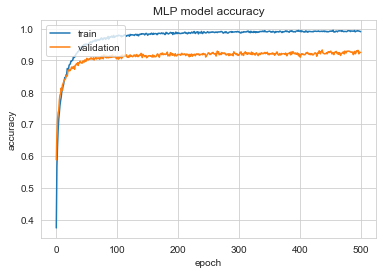

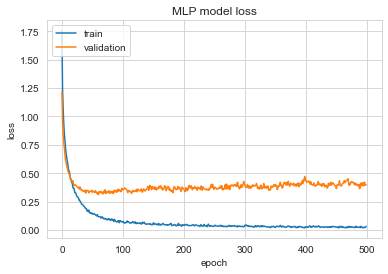

In [19]:
# plot accuracy/error for training and validation
plot_history(model_2_history)

